# EP2 - Modelando o SARS-CoV-2

Hello, little fellows.

In [178]:
import math                          # exp(), ...
import matplotlib.pyplot as pyplot   # plot(), ...
import numpy                         # ones(), ...
import random                        # geração de números aleatórios

# Animação
from matplotlib import animation, rc
from IPython.display import HTML
import requests
import os
from io import BytesIO

Neste EP você vai simular o modelo dinâmico do COVID-19 resolvendo numericamente, por
Euler, a eq. 4 para algumas situações diferentes ligadas aos parâmetros $\alpha, \lambda,$ A e $t_0$.

$\frac{dN}{dt} = \alpha \bigg(1 - \frac{N}{\eta t^2} \bigg)N - \bigg(\frac{2\lambda t^2 - 1}{t} - \frac{\lambda (t_0)^2}{t} e^{-\lambda (t-t_0)^2}\bigg)N$

sendo $\alpha > 0$ o fator de crescimento, $t_0$ o tempo inicial que depende de medidas de restrição, $\lambda = \sigma^{-1}$ e $\eta = 2A/t_0$, onde A é um parâmetro que depende do vírus e das medidas de restrição.

## Método de Euler

Dado o enunciado, a função que nos interessa recebe como parâmetros {$\alpha, \lambda, t_0, A$}. Sua evolução deve ser modelada a partir do método de Euler, por meio do qual se realiza uma aproximação da equação diferencial a partir de diferenças finitas:

$$\frac{dN}{dt} =  \frac{N_{t+1} - N_{t}}{dt} \rightarrow N_{t+1} = N_t + \bigg[\alpha \bigg(1 - \frac{N}{\eta t^2} \bigg)N - \bigg(\frac{2\lambda t^2 - 1}{t} - \frac{\lambda (t_0)^2}{t} e^{-\lambda (t-t_0)^2}\bigg)N \bigg]dt $$

seja $N = N_t$, temos

$$N_{t+1} = N_t + \bigg[\alpha \bigg(1 - \frac{N_t}{\eta t^2} \bigg)N_t - \bigg(\frac{2\lambda t^2 - 1}{t} - \frac{\lambda (t_0)^2}{t} e^{-\lambda (t-t_0)^2}\bigg)N_t \bigg]dt \\ $$

que é o número de pessoas infectadas para um tempo $t$.

In [179]:
# N é o número de pessoas infectadas num certo tempo t

def nextN(N_0, dt, alfa, lamb, t0, A, t):
    eta = (2*A)/t0
    #print(eta)
    
    N  = alfa*(1-N_0/(eta*t**2))
    aux = ((2*lamb*t**2 -1)-(lamb*t0**2)*(math.exp(-lamb*(t-t0)**2)))/t
    #print(aux)
    N -= aux
    N *= N_0
    
    # Euler
    N *= dt
    N += N_0
    
    return N

## Parte 1
$-----------------------------------------------------------$

1. Assumindo que estamos numa ilha isolada, simule a evolução de N para um conjunto {$\alpha, \lambda$, A, $t_0$}. Nesse caso, o vetor de estados é unidimensional v(t) = \[N\](t). Faça um gráfico bonito para mostrar a evolução de v em relação a t, i.e. v(t). Faça também uma simulação dinâmica usando os recursos explicados em aula.

### Simulação 

In [196]:
# Retorna o vetor de estados

def sim():
    # Alguns dos dados abaixo foram retirados do 
    # documento do Sonino para o caso da Itália (p. 12)
    # https://arxiv.org/pdf/2003.13540v5.pdf
    # A maioria é aleatória tho
    
    N_0 = 1            # 165155 - número de casos inicial
    dt = 1              # passo = 1 dia
    t0 = 40             # 70.6 - parâmetro relativo ao pico da curva?
    lamb = 0.001        # 0.0014 - para uma simulação decente, tive que usar na ordem de 10^{-3}
    alfa = 2*t0*lamb    # 0.2 - do pdf do Sonnino, alfa = 2t0*lamb
    A = 100            # 302.5 - 100 - não muda mt coisa
    
    t = 1
    N = N_0
    v = []
    t_f = 100
    
    while(t <= t_f and N >= 1):
        v.append(int(N))
        t += dt
        N = nextN(N, dt, alfa, lamb, t0, A, t)
        
    #print(v)
    return v

### Simulação em Gráfico:

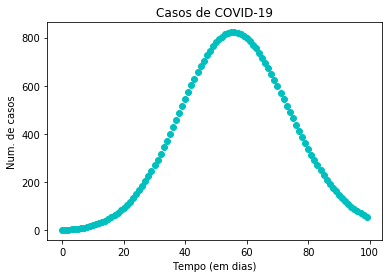

In [197]:
def simPlot(v):
    pyplot.figure()
    pyplot.plot(v,linestyle='',marker='o',color='c')
    pyplot.title('Casos de COVID-19')
    pyplot.ylabel('Num. de casos')
    pyplot.xlabel('Tempo (em dias)')
    pyplot.show()    

simPlot(sim())

### Simulação Dinâmica:

In [198]:
def init_animate():
    line.set_data([], [])
    return (line,)

def animate(i):
    ind0 = i%len(yAnim)
    ind1 = (i+1)%len(yAnim)
    ind1 = ind0
    line.set_data([xAnim[ind0], xAnim[ind1]] , [yAnim[ind0], yAnim[ind1]])
    #ind = i%len(yAnim)
    #line.set_data(xAnim[ind], yAnim[ind]
    return (line,)

def createAnimPlot(title):
    figAnim, axAnim = pyplot.subplots(1, 1)
    axAnim = pyplot.axes(xlim=(-5, 105), ylim=(-50, 860))
    # obs: o eixo muda se mudar os parâmetros de entrada
    
    pyplot.title(title)
    
    line, = axAnim.plot([], [], 'r-*', lw=5, color='c')
    frames=len(yAnim)-1
    
    return(figAnim, axAnim, frames, line)

t = 1
tempo = []
v = sim()
t_f = len(v)

while(t <= t_f):
    tempo.append(t)
    t += 1

#print(v)
#print(tempo)

yAnim = v
xAnim = tempo
figAnim, axAnim, frames, line = createAnimPlot('Casos de COVID-19 ao longo do tempo')
anim = animation.FuncAnimation(figAnim, animate, init_func=init_animate, frames=frames, interval=50, blit=True)
rc('animation', html='jshtml')
pyplot.ylabel('Num. de casos')
pyplot.xlabel('Tempo (em dias)')
pyplot.close()

anim

## Parte 2
$-----------------------------------------------------------$

2. Agora, com sua experiência anterior, simule para cinco ilhas diferentes sorteando os valores de {$\alpha, \lambda$, A, $t_0$}. Nesse caso, o vetor de estados é 5-dimensional v(t) = \[$N_0, N_1, N_2, N_3, N_4$\](t). Faça gráficos bonitos para mostrar a evolução de v em relação a t, i.e. v(t) para as diferentes ilhas. Assim, os gráficos irão mostrar a evolução de $N_i$, onde onde i é um rótulos para cada ilha, em relação a t. Crie igualmente um gráfico mostrando a evolução do módulo de v(t), i.e. $||v(t)||$. Plote também os produtos cartesianos das coordenadas do vetor de estados, i.e. $N_0xN_1, N_0xN_2$, etc., de maneira similar aos gráficos de borboleta das equações de Lorenz. Faça também uma simulação dinâmica usando os recursos explicados em aula.

Visto que $\alpha$ é dependente de $\lambda$ e de $t_0$, os parâmetros sorteados aleatóriamente serão $\lambda, t_0, A$. 

### Simulação

In [201]:
# Retorna o vetor de estados

def sim_rand():
    random.seed(5)
    i = 0
    
    N_0 = []
    N_1 = []
    N_2 = []
    N_3 = []
    N_4 = []
    
    for i in range(0, 5): # vai de 0 a 4
        
        if(i == 0):
            aux = N_0
        elif(i == 1):
            aux = N_1
        elif(i == 2):
            aux = N_2
        elif(i == 3):
            aux = N_3
        else:
            aux = N_4
            
        random_num = random.uniform(0.001, 0.009)
        lamb = random_num   # para uma simulação decente, tive que usar na ordem de 10^{-3}
        
        random_num = random.randint(1, 100)
        t0 = random_num     # parâmetro relativo ao pico da curva?
        
        random_num = random.uniform(1, 999)
        A = random_num      # não muda mt coisa
        
        alfa = 2*t0*lamb    # 0.2 - do pdf do Sonnino, alfa = 2t0*lamb

        init_N = 1          # 165155 - número de casos inicial
        dt = 1              # passo = 1 dia
        t = 1
        N = init_N
        #v = []
        t_f = 100

        while(t <= t_f): #and N >= 1
            aux.append(int(N))
            t += dt
            N = nextN(N, dt, alfa, lamb, t0, A, t)
            if(N < 0):
                N = 0
    
    # Concatenar em v
    v = (N_0, N_1, N_2, N_3, N_4)
        
    print(v)
    #return v

sim_rand()

([1, 2, 5, 10, 21, 42, 82, 153, 279, 492, 829, 1321, 1965, 2705, 3450, 4132, 4740, 5299, 5834, 6361, 6888, 7417, 7950, 8485, 9022, 9559, 10094, 10627, 11155, 11678, 12193, 12698, 13194, 13677, 14148, 14603, 15043, 15465, 15869, 16254, 16620, 16966, 17292, 17600, 17891, 18167, 18431, 18690, 18949, 19216, 19503, 19820, 20184, 20611, 21122, 21740, 22490, 23400, 24500, 25820, 27389, 29235, 31374, 33815, 36543, 39525, 42696, 45964, 49210, 52298, 55084, 57434, 59230, 60382, 60829, 60545, 59533, 57826, 55482, 52582, 49221, 45506, 41548, 37458, 33344, 29302, 25415, 21754, 18369, 15299, 12564, 10170, 8112, 6373, 4930, 3755, 2813, 2073, 1503, 1070], [1, 2, 6, 16, 39, 88, 194, 408, 803, 1434, 2245, 3033, 3664, 4204, 4734, 5276, 5834, 6407, 6992, 7587, 8192, 8803, 9419, 10038, 10658, 11278, 11894, 12506, 13111, 13708, 14294, 14868, 15428, 15972, 16499, 17006, 17492, 17954, 18392, 18804, 19188, 19543, 19868, 20162, 20424, 20657, 20860, 21036, 21191, 21330, 21464, 21604, 21769, 21980, 22264, 22653, 